# Train a neural network for janken with Keras

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras

In [2]:
# Force to use CPU for now
tf.config.set_visible_devices([], 'GPU')

## Create an input pipeline
### Load data

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

### Get the training dataset spec

In [4]:
ds_train_spec = tf.data.DatasetSpec.from_value(ds_train)
ds_train_spec

DatasetSpec((TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)), TensorShape([]))

### Build the training pipeline

1. Scale and cast the `uint8` RGB codes to `float32` in `[0, 1]`.
2. Cache the data pre-shuffle (recommended when it fits in memory).
3. Shuffle.
4. Set up batches.
5. Prefetch (an apparent best practice for [performance reasons](https://www.tensorflow.org/guide/data_performance#prefetching)).

In [5]:
def recast(image, label):
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    recast,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

### Build the test pipeline

Note: caching is done after batching because batches can be the same between epochs?

In [6]:
ds_test = ds_test.map(
    recast,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Create and train the model

In [7]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 298, 298, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 147, 147, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        1

In [9]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [10]:
history = model.fit(ds_train, epochs=6, validation_data=ds_test)

Epoch 1/6
20/20 [==============================] - 276s 14s/step - loss: 4.6809 - accuracy: 0.7409 - val_loss: 5.8120 - val_accuracy: 0.3333
Epoch 2/6
20/20 [==============================] - 265s 13s/step - loss: 0.0157 - accuracy: 0.9964 - val_loss: 11.0848 - val_accuracy: 0.3333
Epoch 3/6
20/20 [==============================] - 267s 13s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 7.9142 - val_accuracy: 0.3333
Epoch 4/6
20/20 [==============================] - 263s 13s/step - loss: 5.8619e-04 - accuracy: 1.0000 - val_loss: 3.3673 - val_accuracy: 0.3844
Epoch 5/6
20/20 [==============================] - 261s 13s/step - loss: 3.9088e-04 - accuracy: 1.0000 - val_loss: 1.9610 - val_accuracy: 0.4059
Epoch 6/6
20/20 [==============================] - 261s 13s/step - loss: 3.0741e-04 - accuracy: 1.0000 - val_loss: 3.1351 - val_accuracy: 0.3333


## Review the history

In [11]:
import matplotlib.pyplot as plt

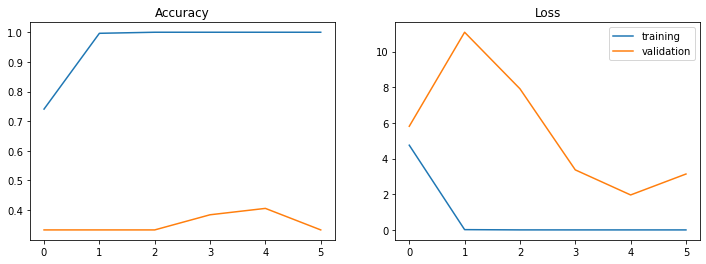

In [12]:
fig, (acc, los) = plt.subplots(1, 2, figsize=(12, 4))

acc.plot(history.epoch, history.history['accuracy'], label='training')
acc.plot(history.epoch, history.history['val_accuracy'], label='validation')
acc.set_title('Accuracy')
los.plot(history.epoch, history.history['loss'], label='training')
los.plot(history.epoch, history.history['val_loss'], label='validation')
los.set_title('Loss')
plt.legend(loc='best')

## Save the model

In [13]:
model.save('janken_take_2.h5')